In [1]:
from hiive.mdptoolbox import example,mdp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import random
import math
import time as time

In [2]:
plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=10) #fontsize of the title
plt.rc('axes', labelsize=10) #fontsize of the x and y labels
plt.rc('xtick', labelsize=8) #fontsize of the x tick labels
plt.rc('ytick', labelsize=8) #fontsize of the y tick labels
plt.rc('legend', fontsize=10) #fontsize of the legend
plt.rc('figure',figsize = (3, 3),dpi=300)
plt.rc('savefig',dpi=300)
plt.rc('lines',markersize=1)


In [ ]:
RANDOM_STATE=29
SPACES=["S","G","F","H"]
ARROWS=[
    "\u2190", #left
    "\u2193", #down
    "\u2192", #right
    "\u2191", #up
    ]

In [300]:
def plot_policy_value(q,title):

    fig,axs=plt.subplots(1,2,figsize=(6,3))

   
    ax=axs[0]
    ax.set_yticks(range(0,size,5))
    ax.imshow(world_viz,cmap=colors.ListedColormap(['gray','seagreen','white','royalblue']))

    policy_viz=np.array(list(map(lambda x: ARROWS[x],q.policy))).reshape(world_viz.shape)
    for y in range(policy_viz.shape[0]):
        for x in range(policy_viz.shape[1]):
            if world_viz[y,x] in [3,1]:
                continue
            ax.text(x, y,policy_viz[y, x],fontsize=8,
                    horizontalalignment='center',
                    verticalalignment='center',
                    )
    ax.set_title("Policy")
    ax=axs[1]
    ax.set_title("Values")
    value_viz=np.array(q.V).reshape(world_viz.shape)
    im=ax.imshow(value_viz,cmap='Purples')
    fig.subplots_adjust(right=0.8)
    fig.colorbar(im,cax=fig.add_axes([0.85, 0.2, 0.025, 0.6]))
    ax.set_yticks(range(0,size,5))
    fig.suptitle(title)
    plt.show()
    

In [11]:
row="F"*8
row

'FFFFFFFF'

In [177]:
size=10
world=[]
random.seed(30)
for i in range(size):
    row=""
    for j in range(size):
        if (i+j)==0:
            row+="S"
        elif (i==(size-1) and j==(size-1)):
            row+="G"
        elif random.random()<0.1:
            row+="H"
        else:
            row+="F"
    world.append(row)
world_viz=np.ndarray([len(world),len(world[0])])
for i in range(len(world)):
    for j in range(len(world[0])):
        world_viz[i,j]=SPACES.index(world[i][j])
world
    

['SFFHFFFFFF',
 'FFFFHFFFFF',
 'FFHHFFFFFF',
 'FFFFFFFHFF',
 'FFFFFFFFFF',
 'FHFFFFFFFF',
 'FFFFFFFFFF',
 'FFFFFFFFFF',
 'FFFFFFFHFF',
 'FFFHFHFFFG']

In [289]:

P,R=example.openai('FrozenLake-v1',**{'desc':world,"is_slippery":True})
R=[np.zeros((size*size,size*size))]*4
for states in R:
	states[:-1,-1]=1




# Value Iterations

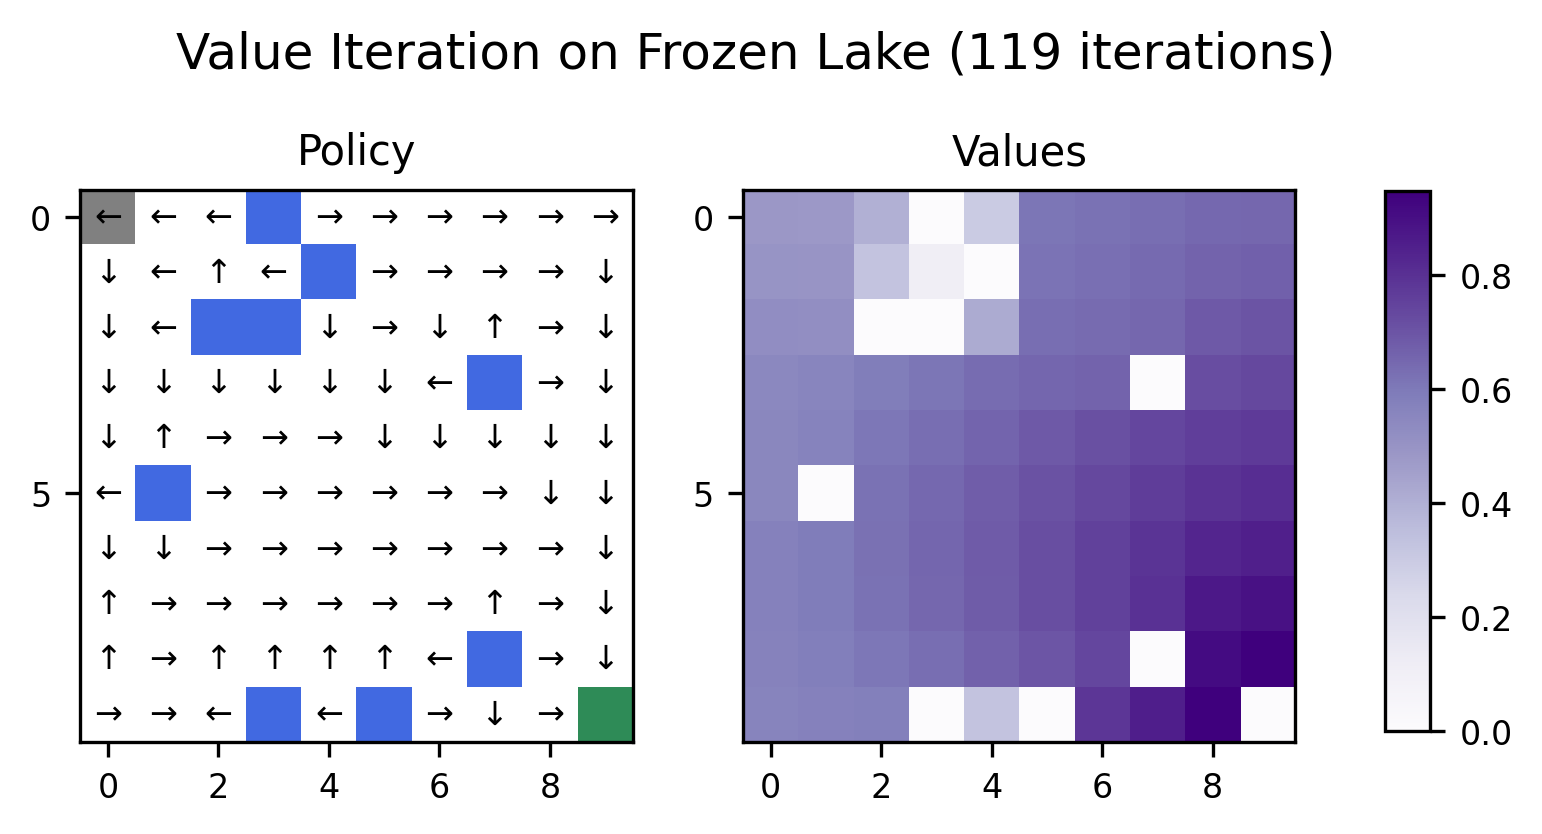

In [446]:
vi = mdp.ValueIteration(P, R, 0.99,run_stat_frequency=1,epsilon=1e-3,max_iter=100000)
vi_run_stats=vi.run()

plot_policy_value(vi,f"Value Iteration on Frozen Lake ({len(vi_run_stats)} iterations)")



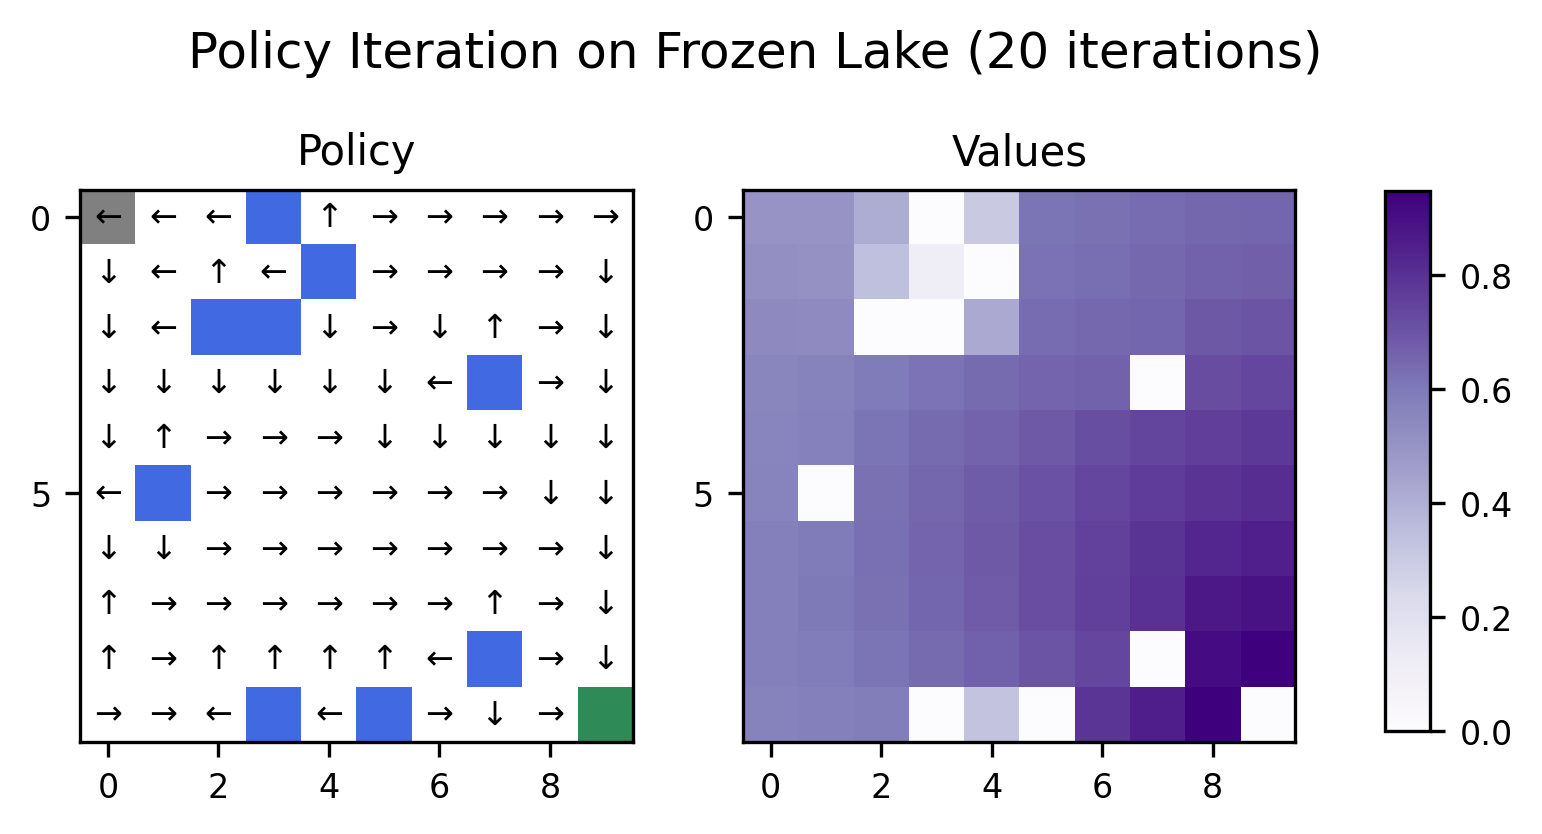

In [450]:
pi=mdp.PolicyIteration(P,R,0.99,eval_type=0,run_stat_frequency=1,policy0=None,max_iter=20)
pi_run_stats=pi.run()

plot_policy_value(pi,f"Policy Iteration on Frozen Lake ({len(pi_run_stats)} iterations)")

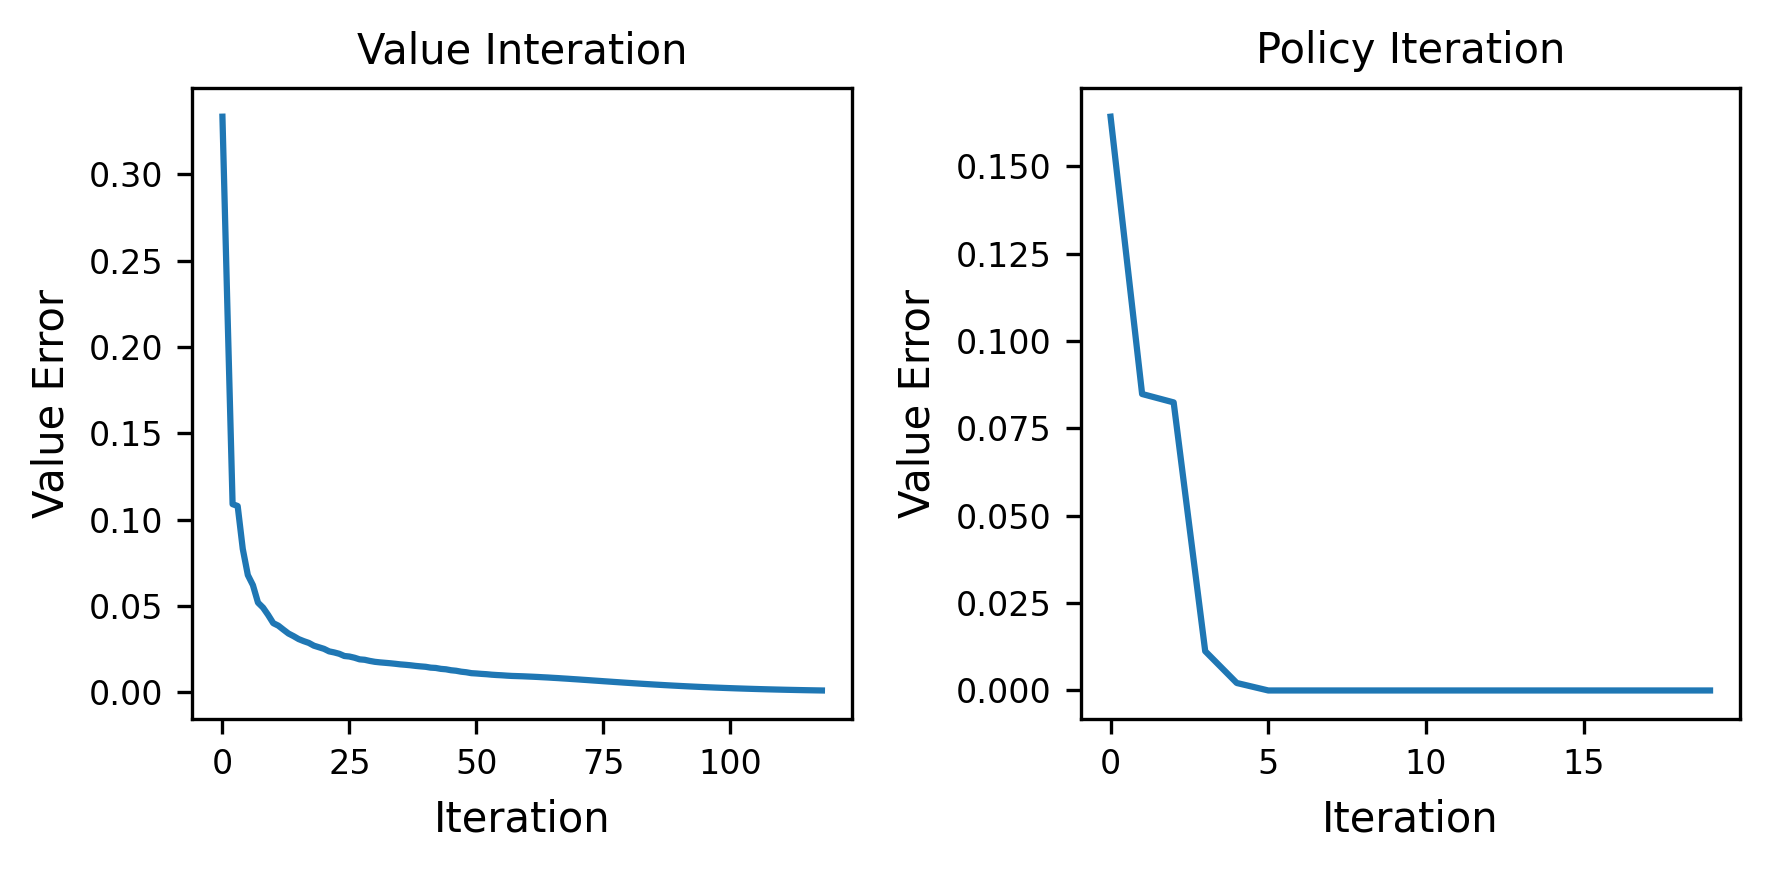

In [449]:
fig,axs=plt.subplots(1,2,figsize=(6,3))

for ax,run_stats,title in zip(axs,(vi_run_stats,pi_run_stats),['Value Interation','Policy Iteration']):
    ax.plot([i['Error'] for i in run_stats])
    ax.set_title(title)
    ax.set_ylabel("Value Error")
    ax.set_xlabel("Iteration")
plt.tight_layout()

# Q-Learning

In [420]:
class MyQLearning(mdp.QLearning):
    def run(self,plot=False,plot_freq=10000):
        # Run the Q-learning algorithm.
 
        self.run_stats = []


        self.time = time.time()
        self.episode_end=[]
        # initial state choice
        s = 0
        reset_s = False
        run_stats = []

        self.episode_lengths=[]
        self.error_per_episode=[0]
        self.episode_mean_Q=[]
        last_episode_end=0
        current_episode=1
        for n in range(1, self.max_iter + 1):


            # Reinitialisation of trajectories every 100 transitions
            if reset_s:
                s = 0
                self.episode_lengths.append(n-last_episode_end)
                last_episode_end=n
                self.episode_mean_Q.append(np.mean(self.Q))
                self.episode_end.append(n-1)
                if ((current_episode%plot_freq)==0 and plot):
                    plot_policy_value(self,f"Q-Learning on Frozen Lake ({current_episode} Episodes)")

                if sum(self.error_per_episode[-10:])<1e-2:
                    break                
                self.error_per_episode.append(0)
                current_episode+=1


            # Action choice : greedy with increasing probability
            # The agent takes random actions for probability ε and greedy action for probability (1-ε).
            pn = np.random.random()
            if pn < self.epsilon:
                a = np.random.randint(0, self.A)
            else:
                # optimal_action = self.Q[s, :].max()
                a = self.Q[s, :].argmax()

            # Simulating next state s_new and reward associated to <s,s_new,a>
            p_s_new = np.random.random()
            p = 0
            s_new = -1
            while (p < p_s_new) and (s_new < (self.S - 1)):
                s_new = s_new + 1
                p = p + self.P[a][s, s_new]

            try:
                r = self.R[a][s, s_new]
            except IndexError:
                try:
                    r = self.R[s, a]
                except IndexError:
                    r = self.R[s]

            # Q[s, a] = Q[s, a] + alpha*(R + gamma*Max[Q(s’, A)] - Q[s, a])
            # Updating the value of Q

            dQ = self.alpha * (r + self.gamma * self.Q[s_new, :].max() - self.Q[s, a])
            self.Q[s, a] = self.Q[s, a] + dQ

            # Computing means all over maximal Q variations values
            error = np.absolute(dQ)
            self.error_per_episode[-1]+=error
            # compute the value function and the policy
            v = self.Q.max(axis=1)
            self.V = v
            p = self.Q.argmax(axis=1)
            self.policy = p

            self.S_freq[s,a] += 1
            run_stats.append(self._build_run_stat(i=n, s=s, a=a, r=r, p=p, v=v, error=error))


            self.run_stats.append(run_stats[-1])
            run_stats = []
            

            reset_s = (world_viz.flatten()[s]==1) or (world_viz.flatten()[s]==3) 

            # current state is updated
            s = s_new

            self.alpha *= self.alpha_decay
            if self.alpha < self.alpha_min:
                self.alpha = self.alpha_min

            self.epsilon *= self.epsilon_decay
            if self.epsilon < self.epsilon_min:
                self.epsilon = self.epsilon_min

        self._endRun()
        # add stragglers
        if plot:
            plot_policy_value(self,f"Q-Learning on Frozen Lake ({current_episode} Episodes)")

        if self.run_stats is None or len(self.run_stats) == 0:
            self.run_stats = run_stats
        return self.run_stats

Implement and see results

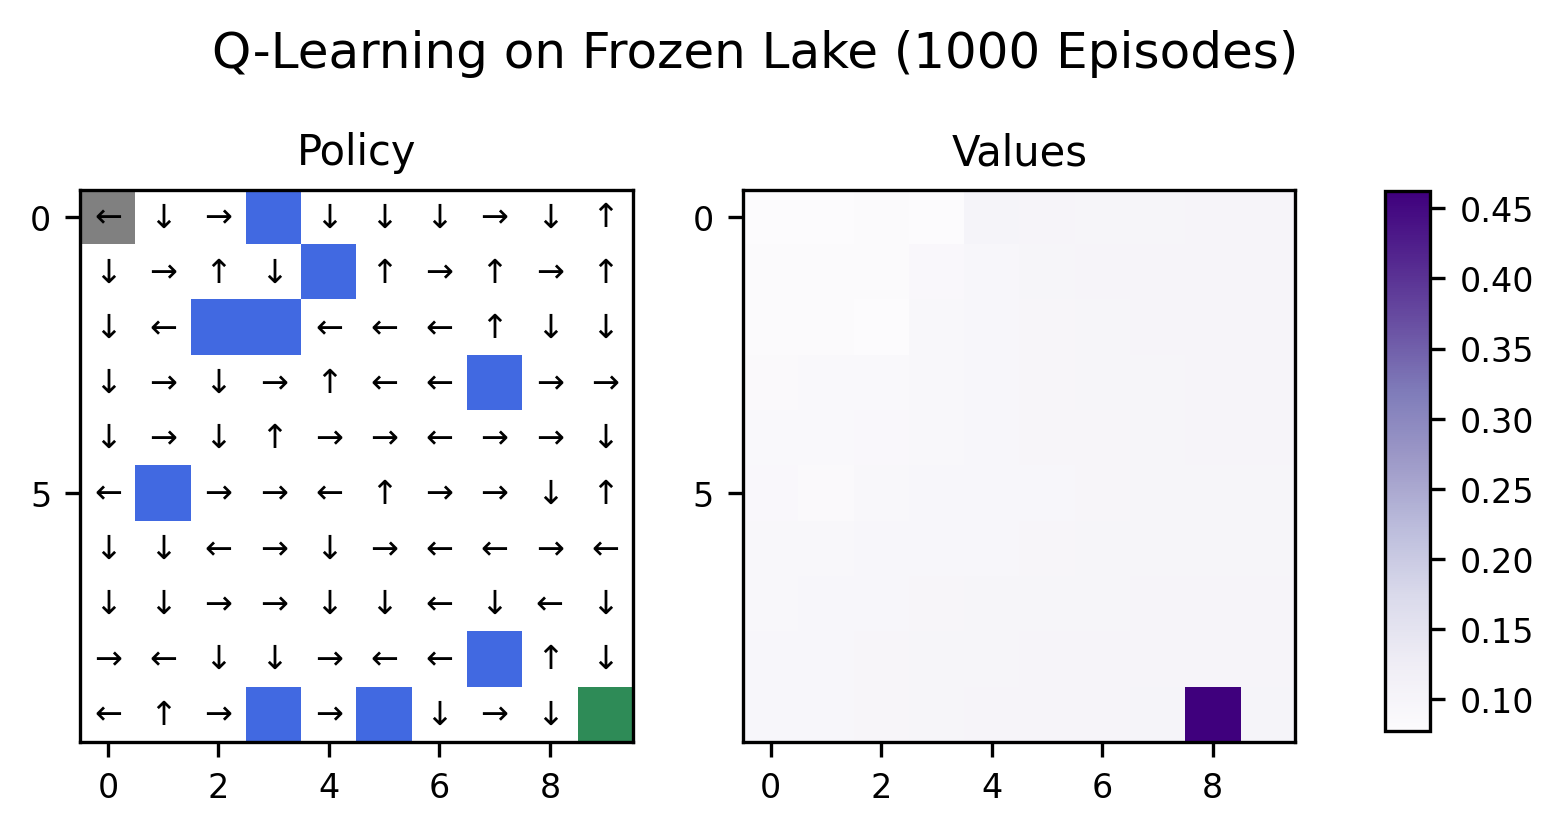

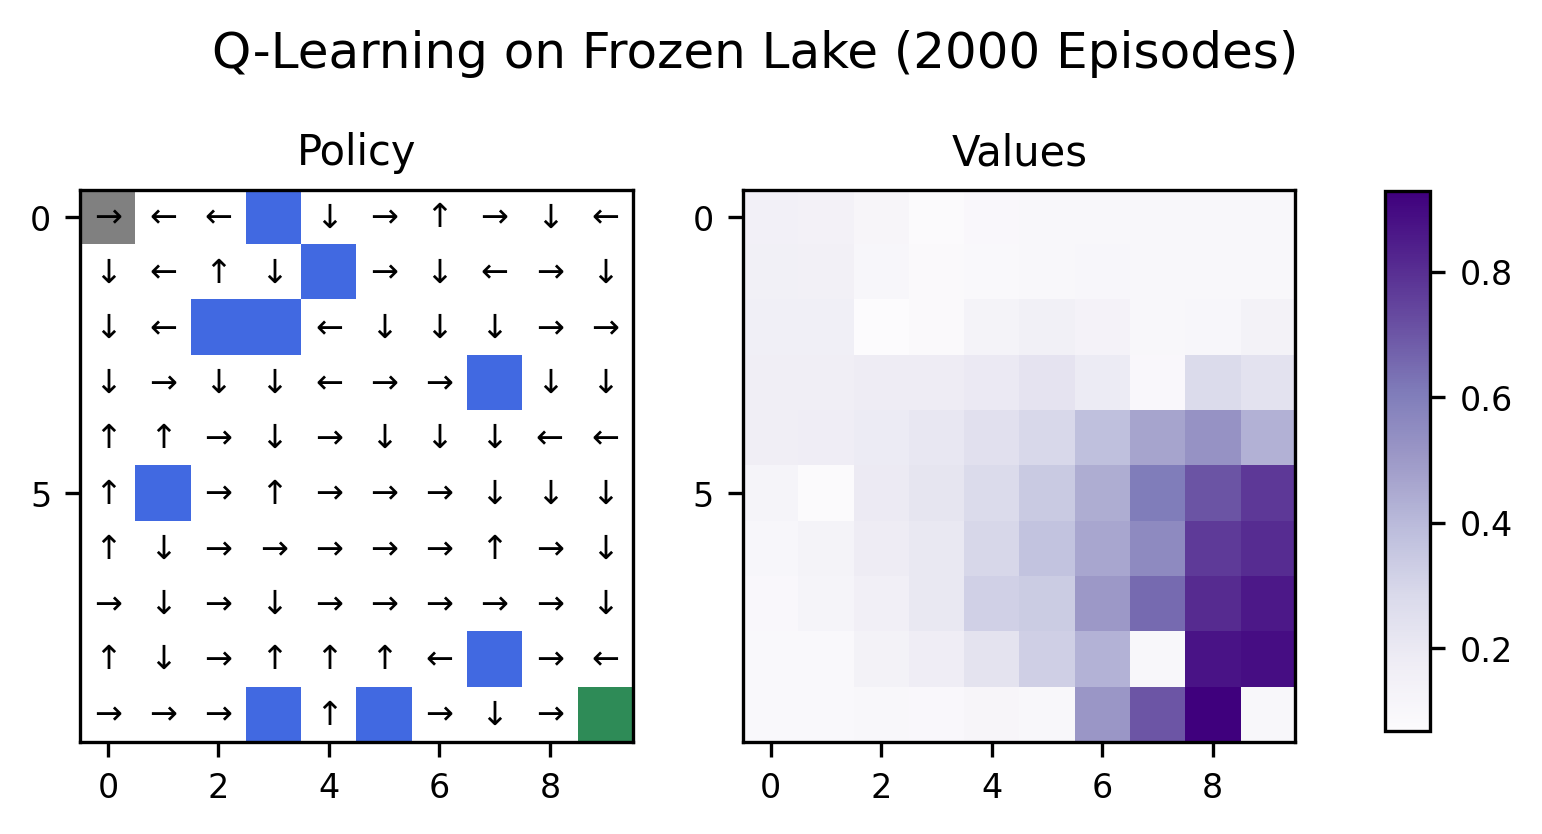

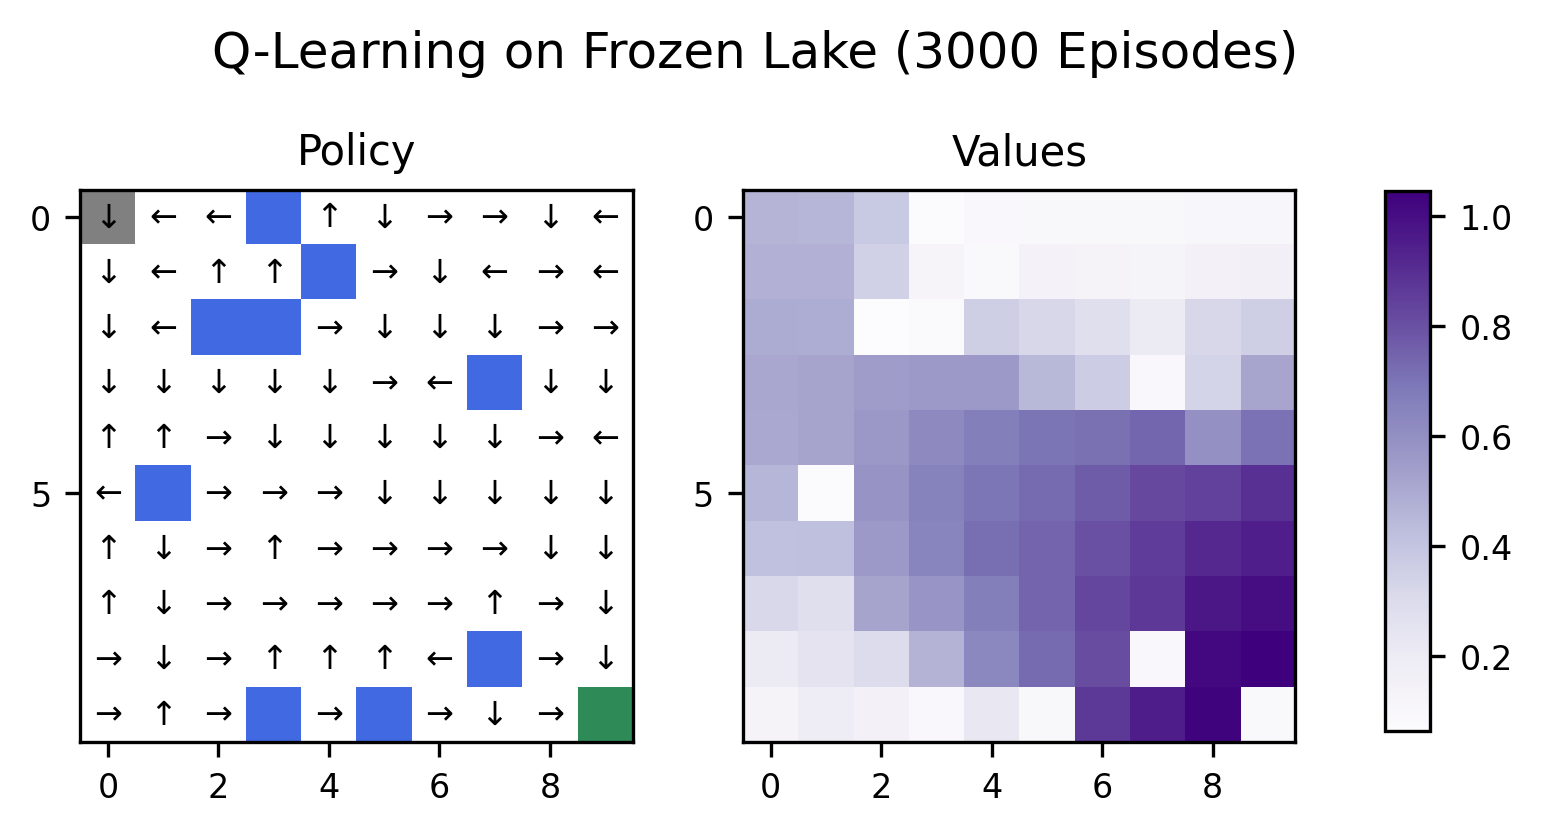

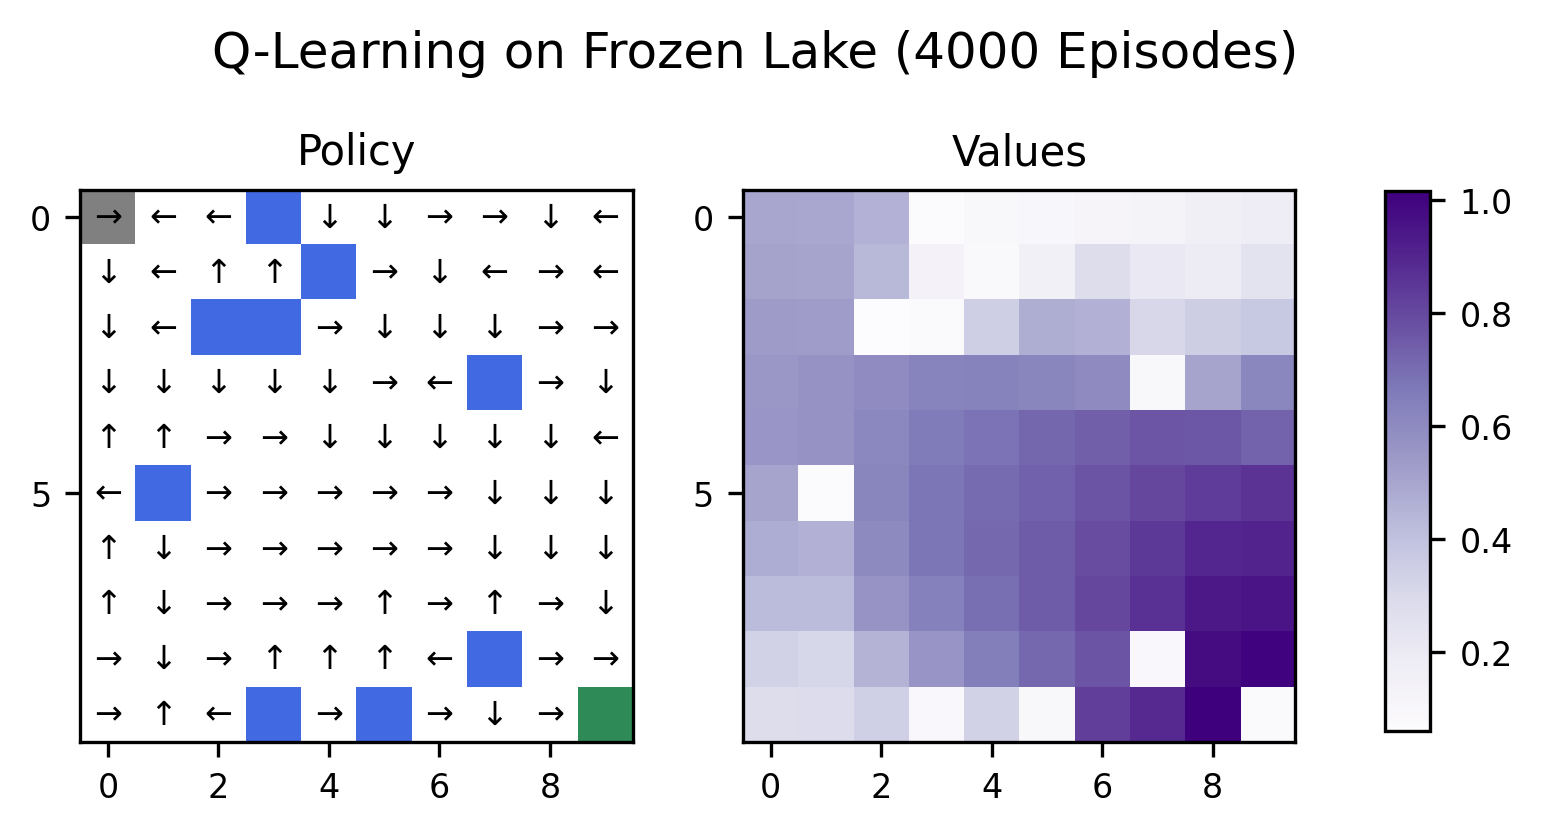

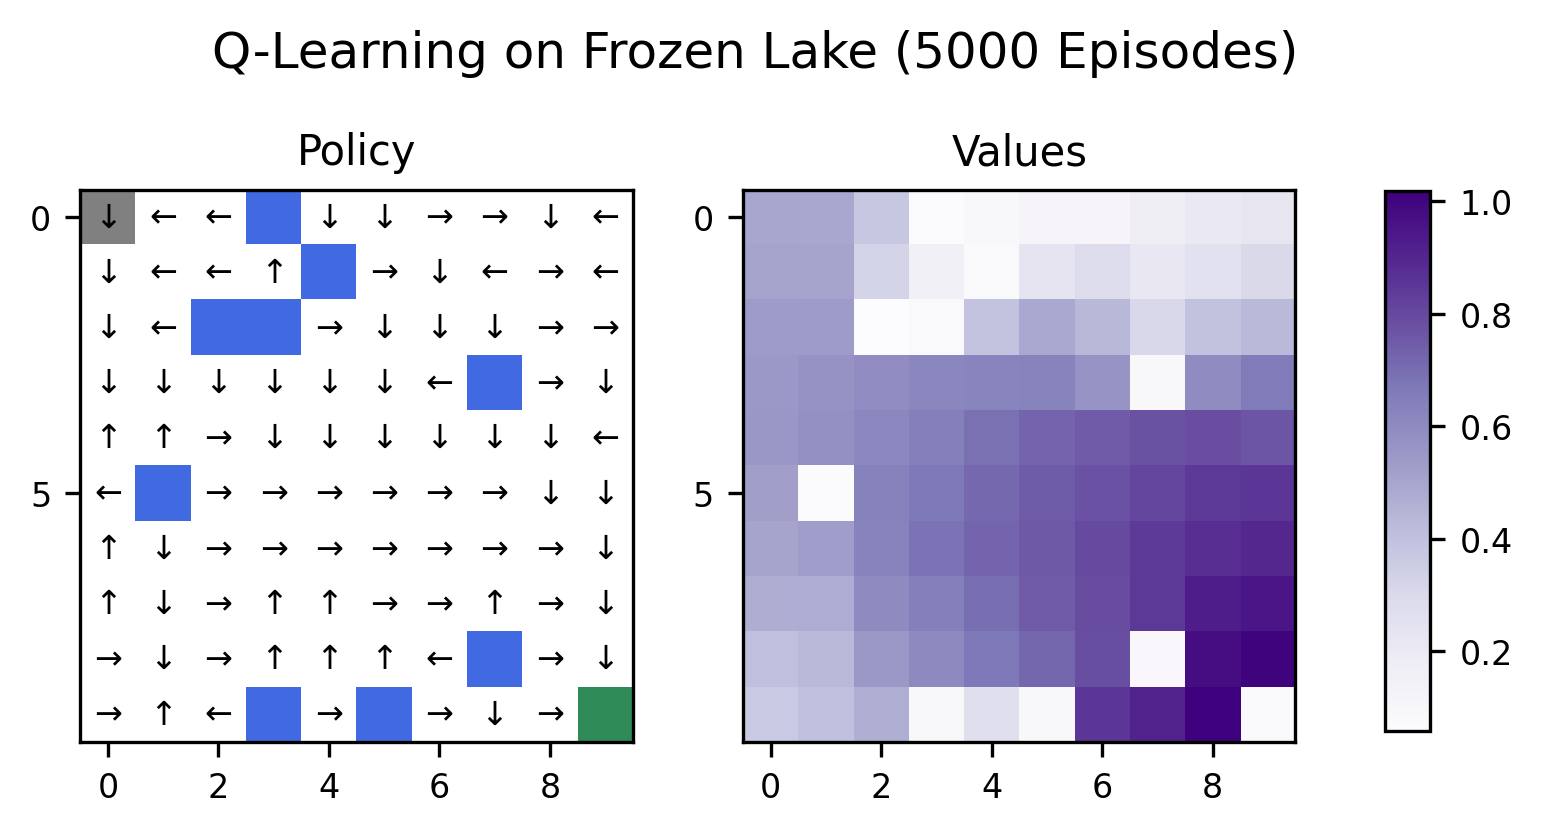

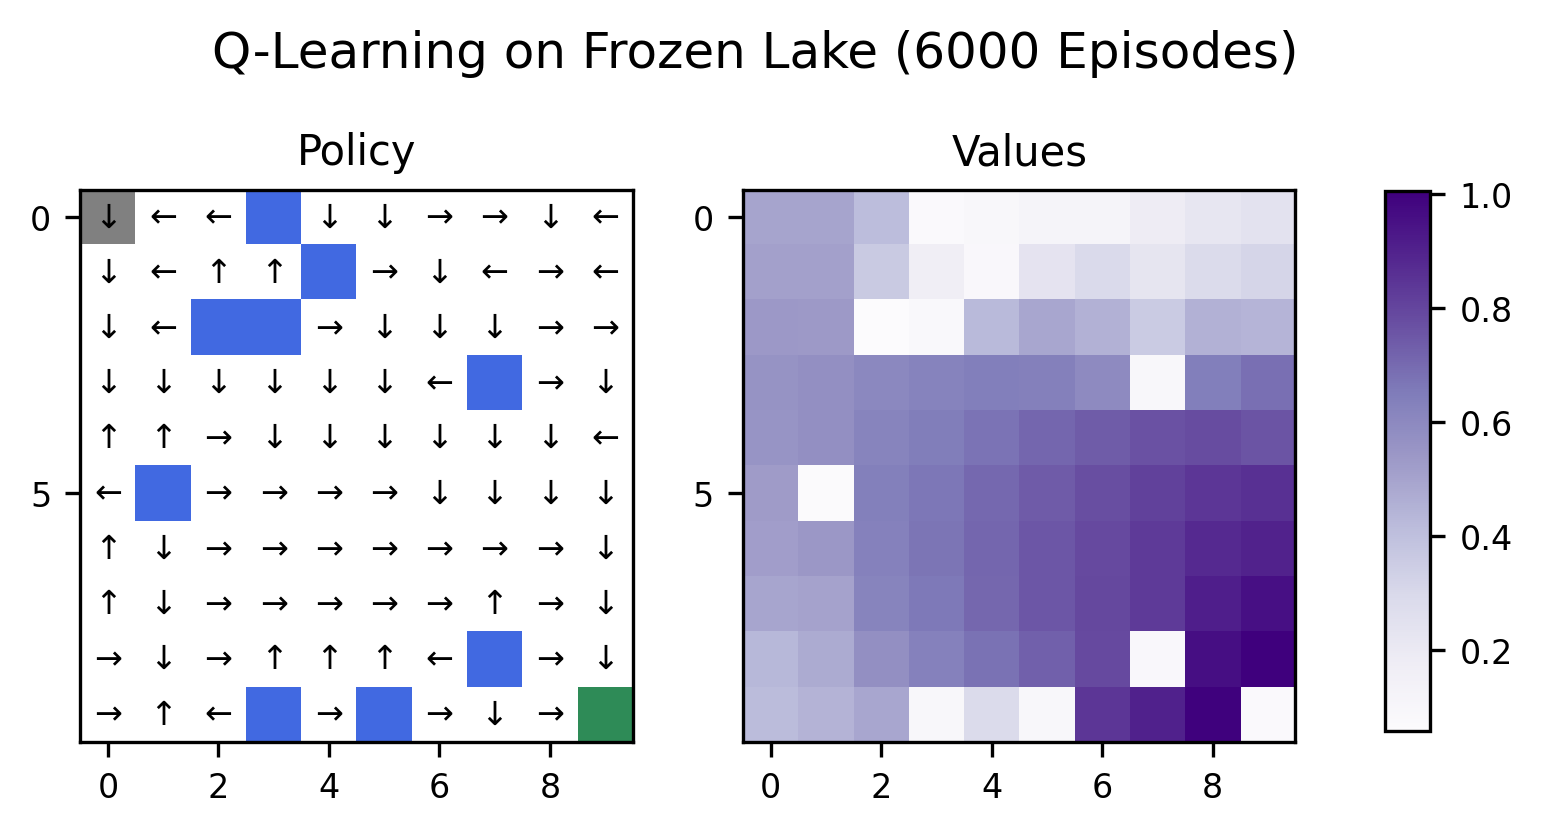

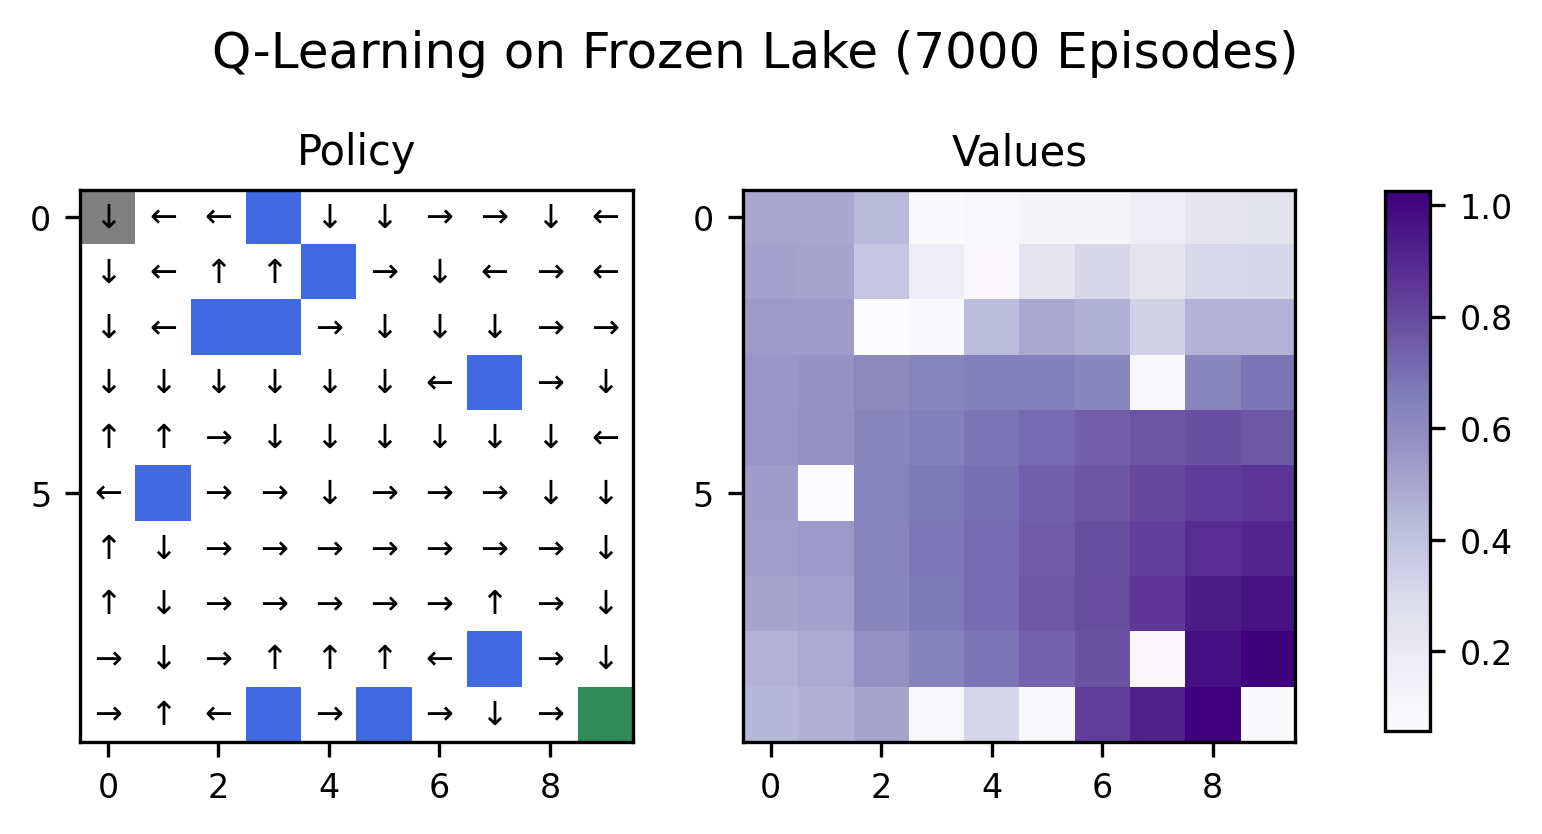

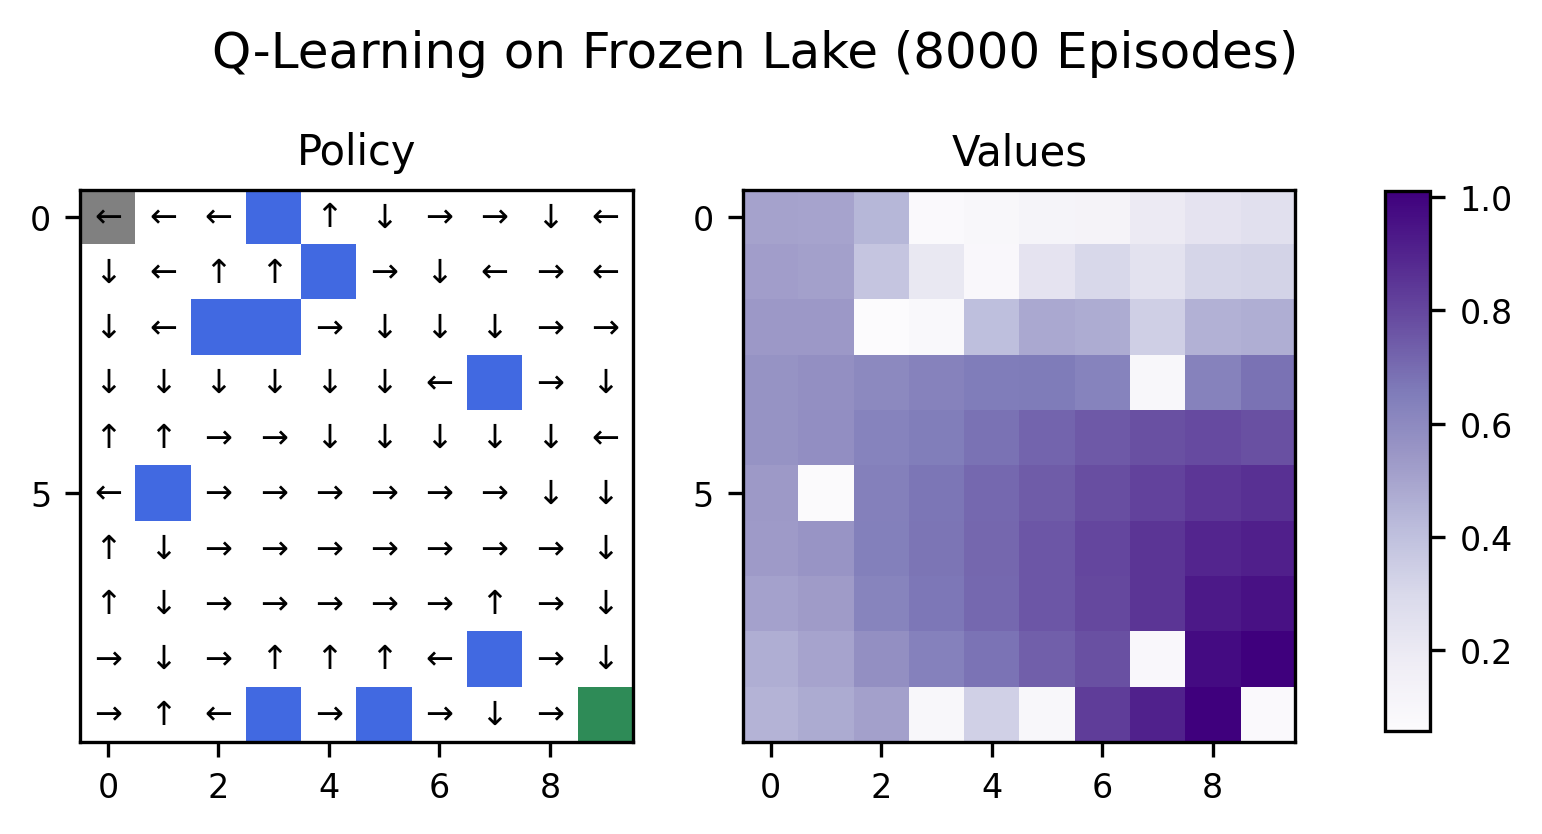

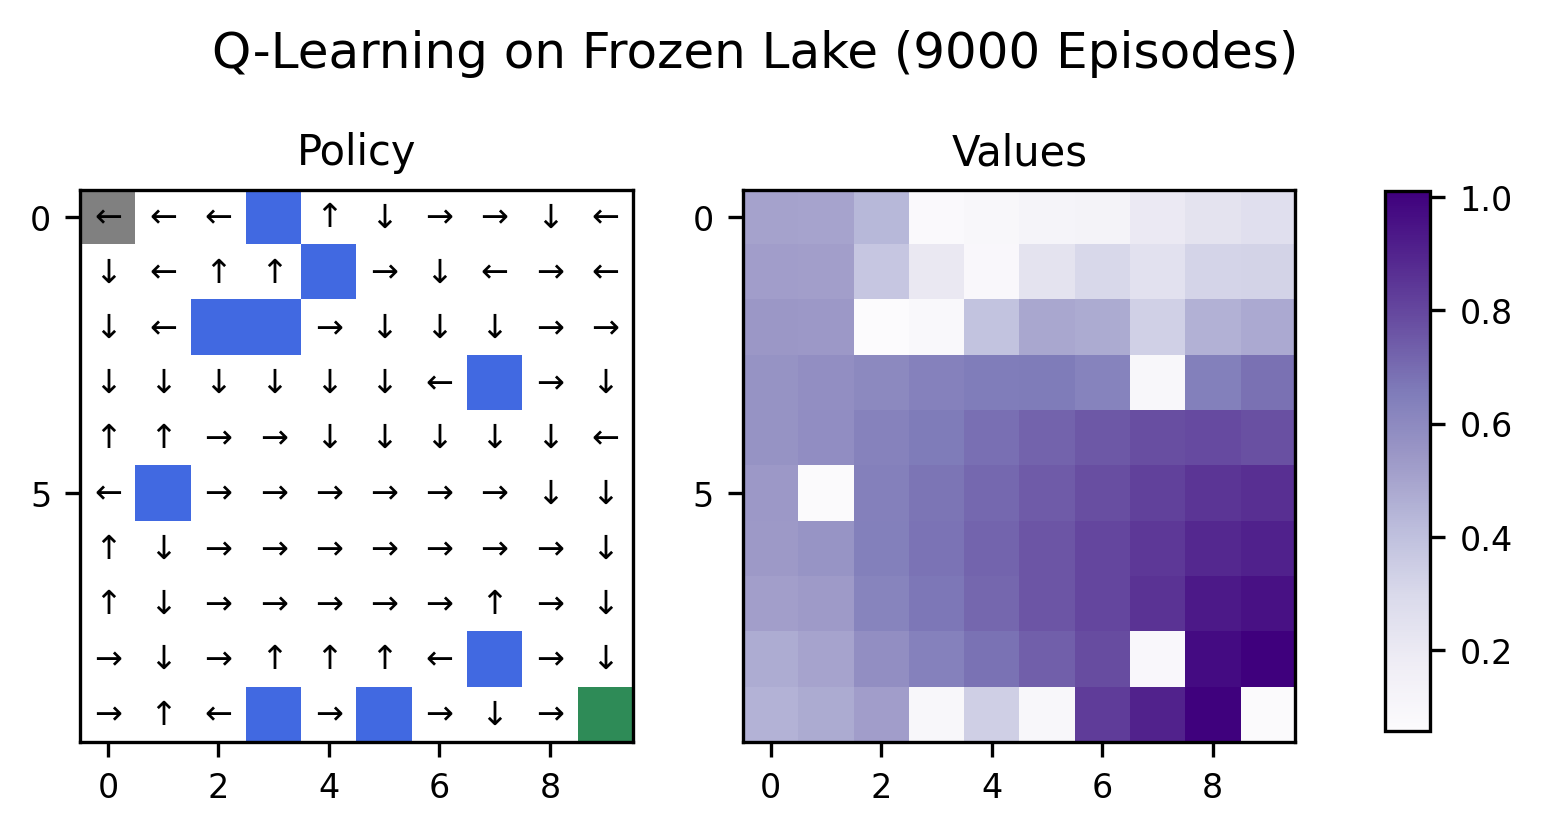

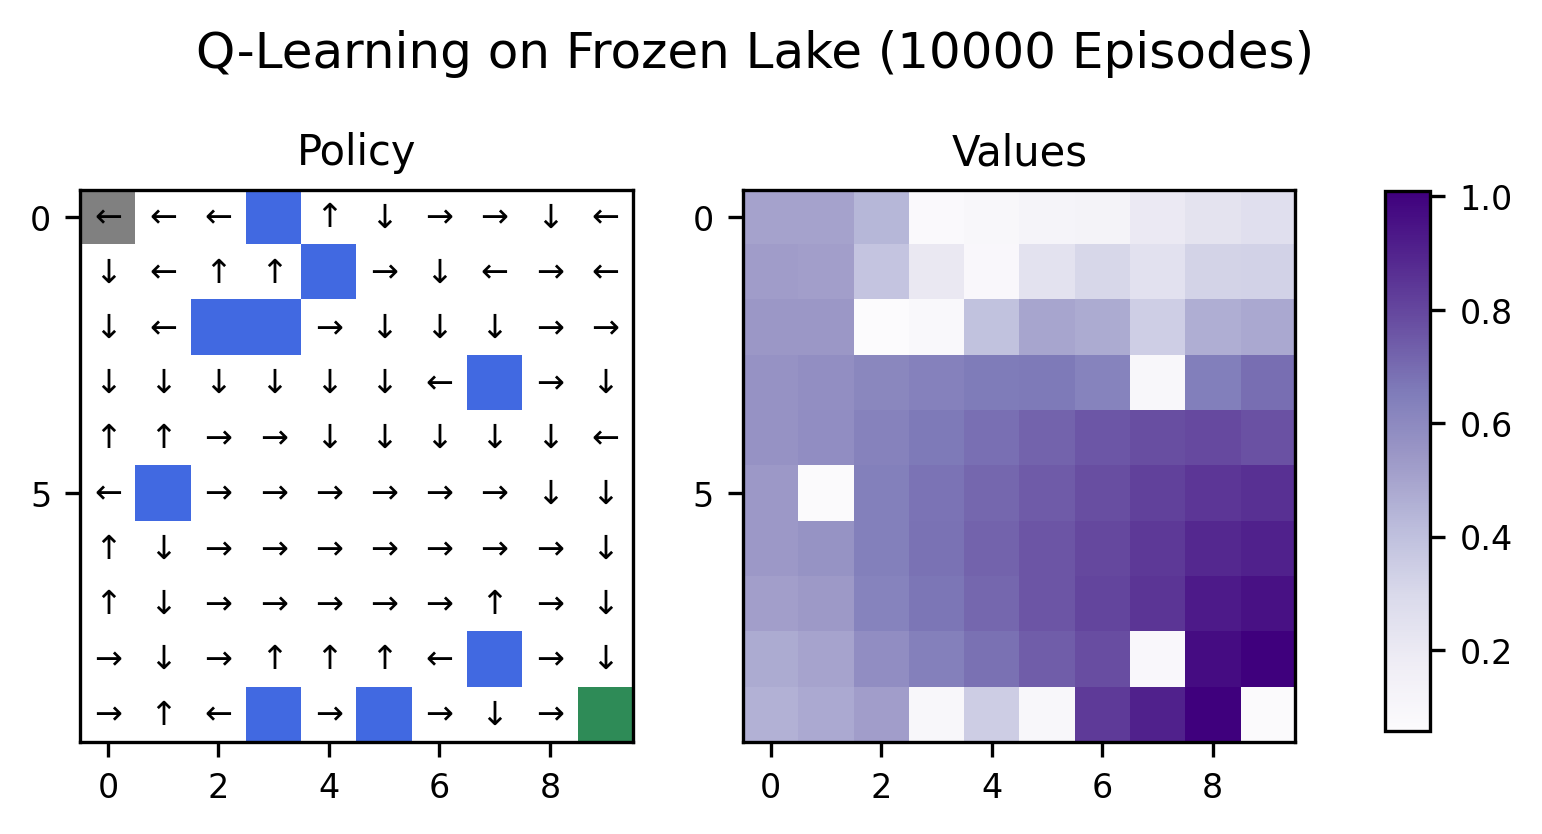

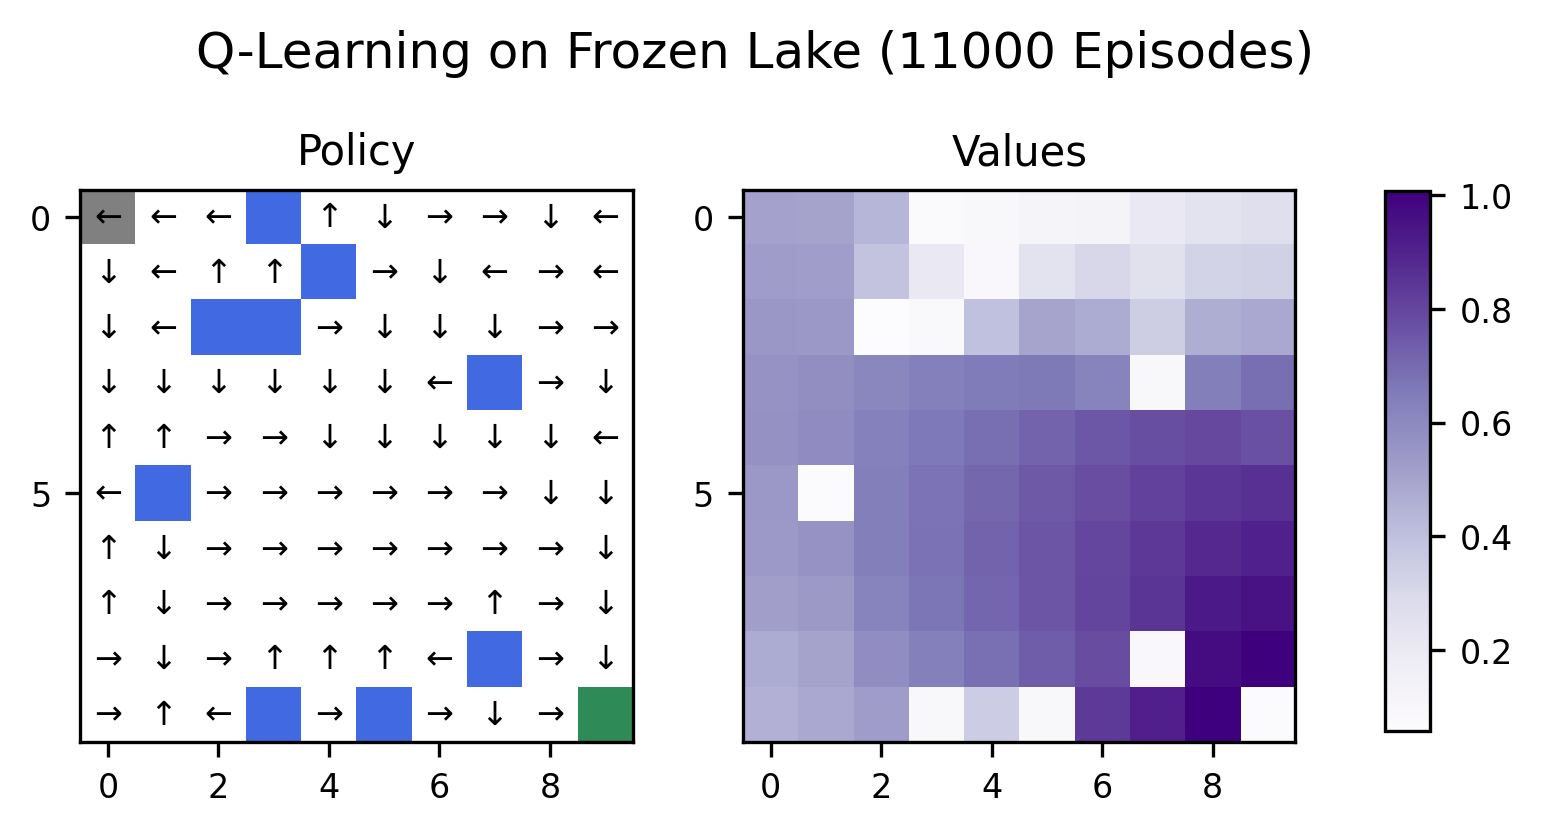

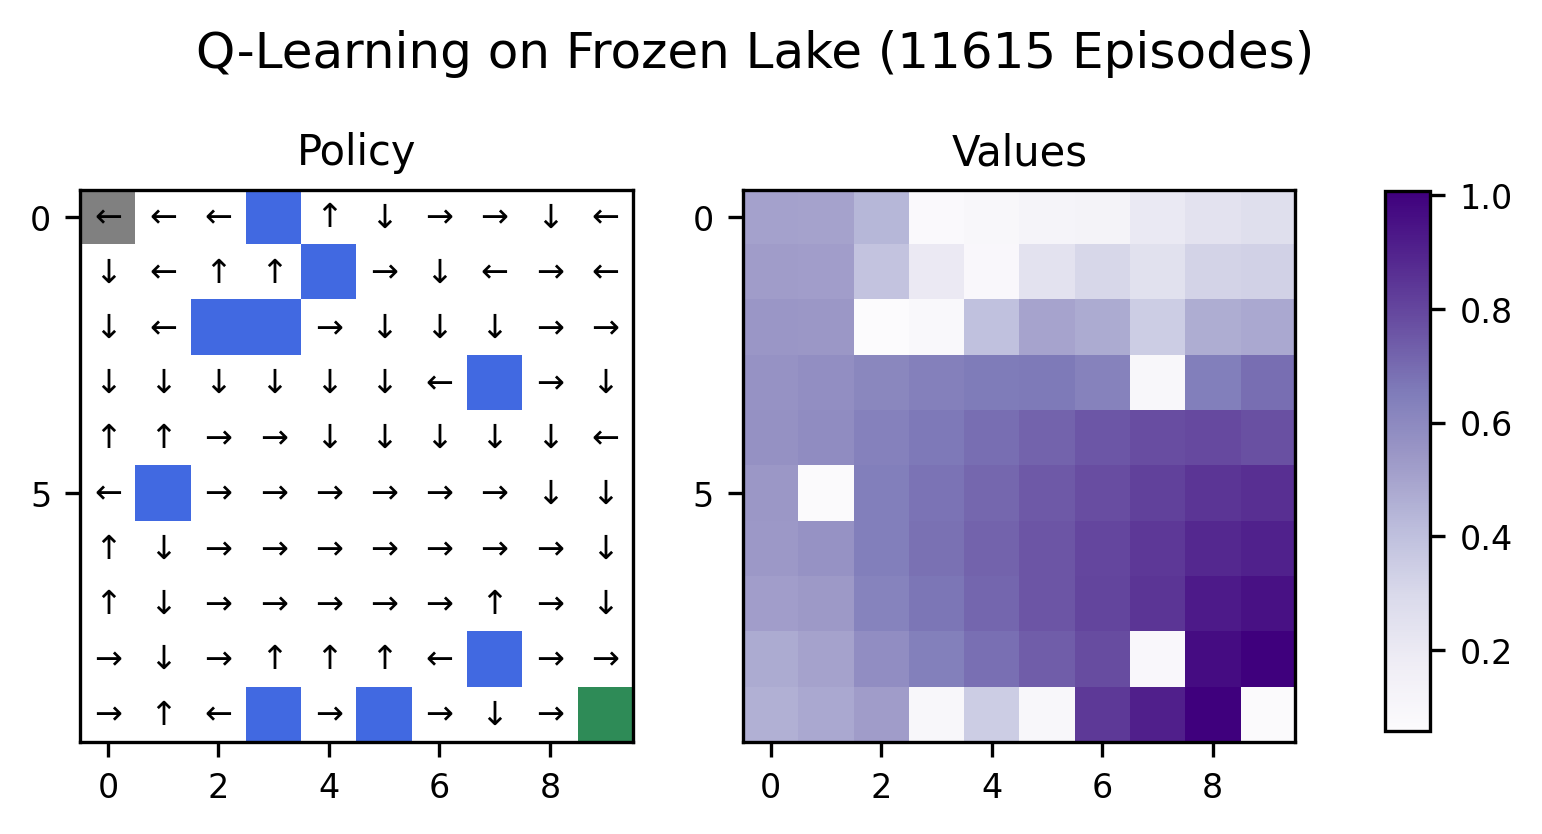

0.001 0.00033378349955288586


In [459]:
np.random.seed(RANDOM_STATE)
#q=MyQLearning(P,R,0.99,n_iter=5e5,epsilon_min=0.1,epsilon=1,alpha_min=0.001,alpha=0.99,alpha_decay=0.99999,epsilon_decay=0.9)
q=MyQLearning(P,R,0.99,n_iter=1e6,epsilon_min=0.2,epsilon=1,alpha_min=0.001,alpha=0.4,alpha_decay=0.99999,epsilon_decay=0.9)
q.Q[:,:]=0.1
q_run_stats=q.run(plot=True,plot_freq=1000)
print(q.alpha,q.error_per_episode[-1])

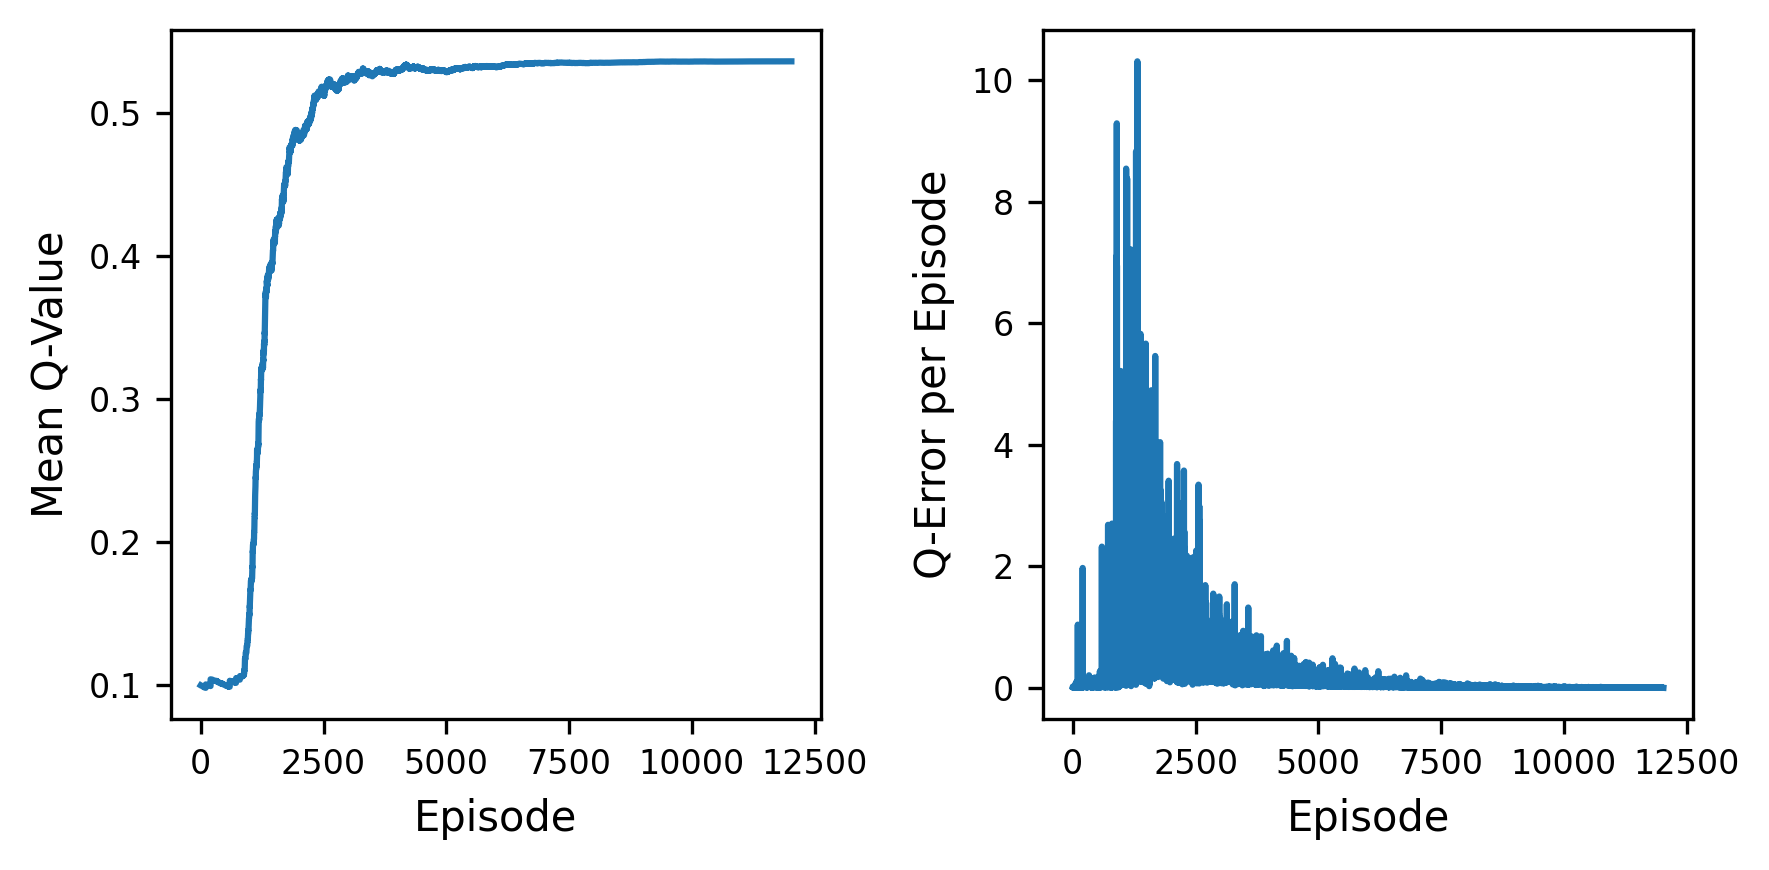

In [458]:
fig,axs=plt.subplots(1,2,figsize=(6,3))

ax=axs[0]

ax.plot(q.episode_mean_Q,label=p)

ax.set_xlabel("Episode")

ax.set_ylabel("Mean Q-Value")


ax=axs[1]

ax.plot(q.error_per_episode,label=p)
ax.set_xlabel("Episode")
ax.set_ylabel("Q-Error per Episode")
plt.tight_layout()

Tune final learning rate

0.14715170288842302
0.001
0.08695478248767033


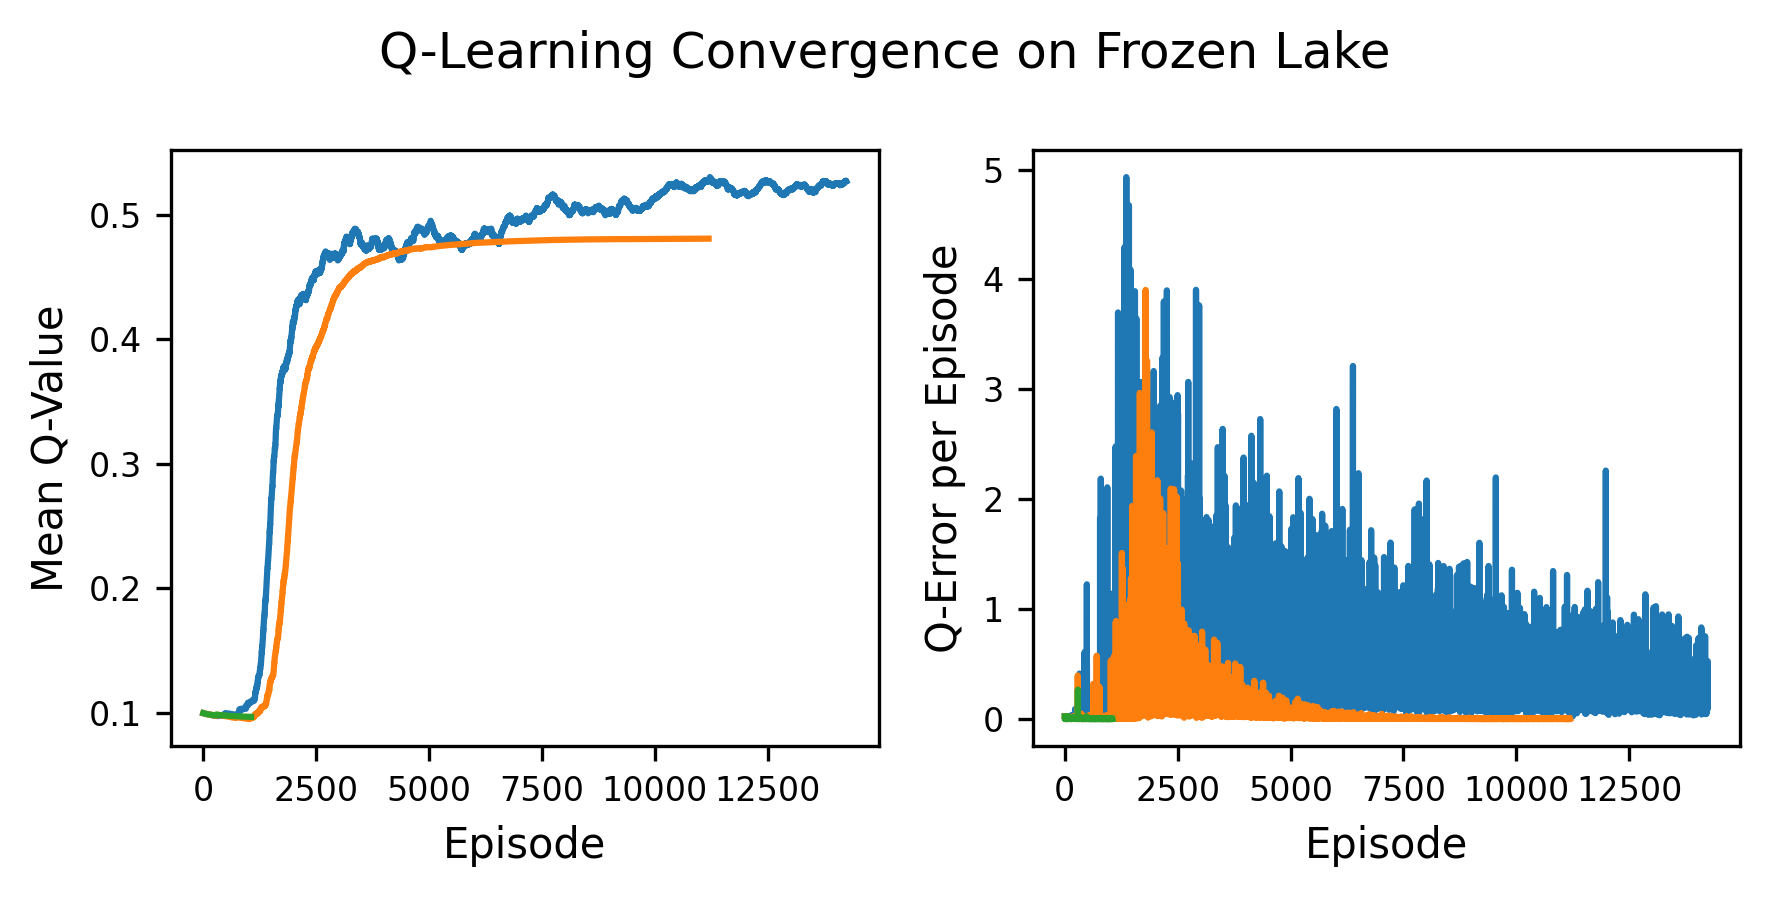

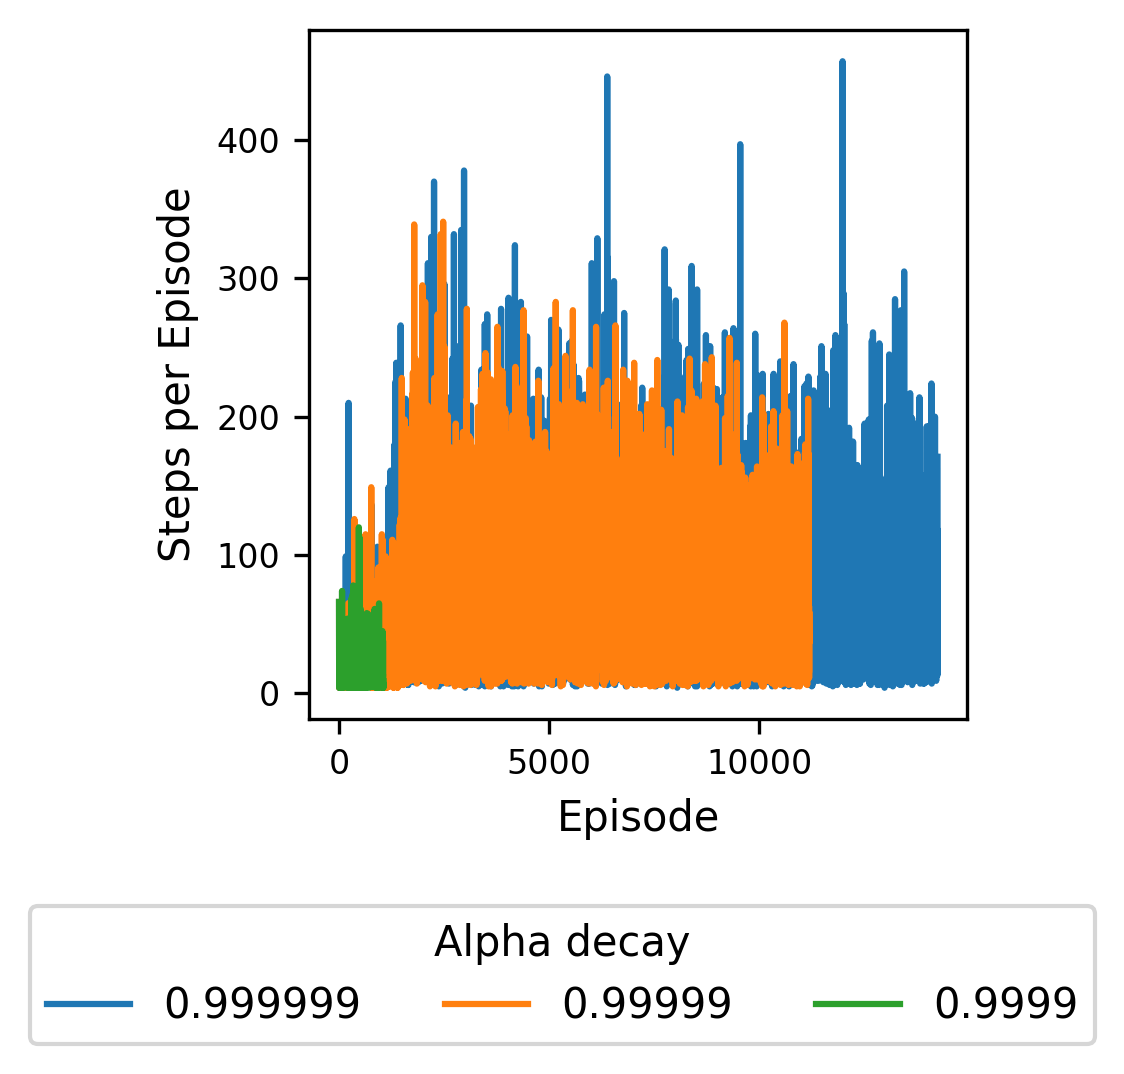

In [428]:

params=[0.999999,0.99999,0.9999]
q_run_stats=[]
run_resets=[]
fig,axs=plt.subplots(1,2,figsize=(6,3))
fig2,axs2=plt.subplots(1,1,figsize=(3,3))
handles = []
for i,p in enumerate(params):
    np.random.seed(RANDOM_STATE)
    _q=MyQLearning(P,R,0.99,n_iter=1e6,epsilon_min=0.1,epsilon=1,alpha_min=0.001,alpha=0.4,alpha_decay=p,epsilon_decay=0.9)
    _q.Q[:,:]=0.1
    _q.run(plot=False)
    print(_q.alpha)

    ax=axs2
    ax.plot(_q.episode_lengths)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Steps per Episode")
    ax=axs[0]
    handles.append(ax.plot(_q.episode_mean_Q,label=p)[0])
    
    ax.set_xlabel("Episode")

    ax.set_ylabel("Mean Q-Value")


    ax=axs[1]

    ax.plot(_q.error_per_episode,label=p)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Q-Error per Episode")



fig.suptitle("Q-Learning Convergence on Frozen Lake")
fig.tight_layout()


fig2.legend(handles, params, bbox_to_anchor=(0.5, -0.1),ncol=len(handles),loc='center',title="Alpha decay")
fig2.tight_layout()

0.001
0.001
0.001


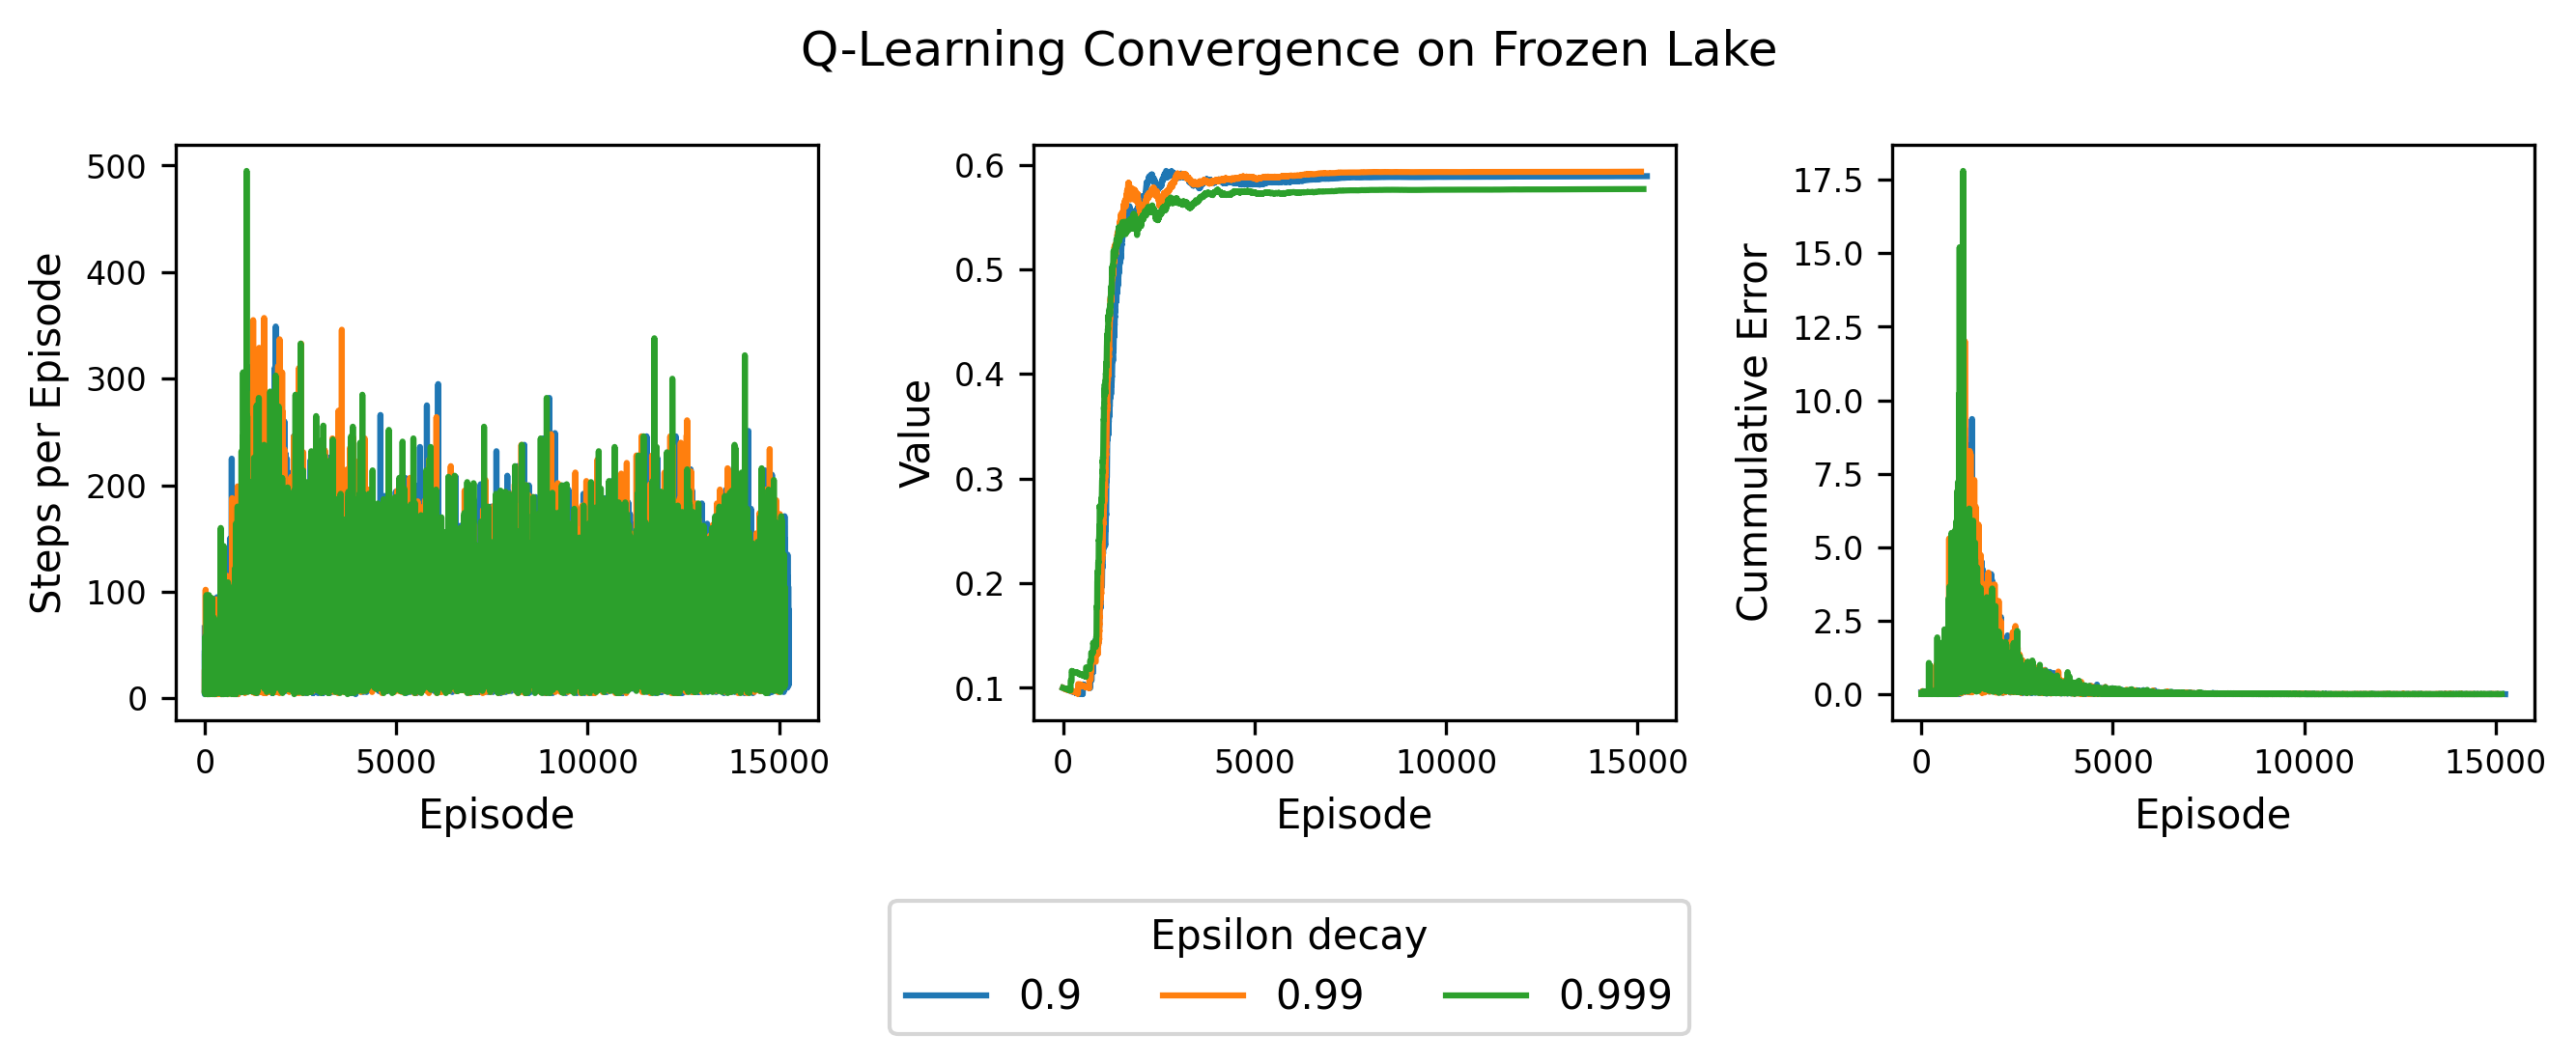

In [244]:

params=[0.9,0.99,0.999]
q_run_stats=[]
run_resets=[]
fig,axs=plt.subplots(1,3,figsize=(9,3))
handles = []
for i,p in enumerate(params):
    np.random.seed(RANDOM_STATE)
    q=MyQLearning(P,R,0.99,n_iter=1e6,epsilon_min=0.1,epsilon=1,alpha_min=0.001,alpha=0.99,alpha_decay=0.99999,epsilon_decay=p)
    q.Q[:,:]=0.1
    run_stats=q.run()
    print(q.alpha)

    ax=axs[0]
    ax.plot(q.episode_lengths)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Steps per Episode")
    ax=axs[1]
    handles.append(ax.plot(q.episode_mean_v,label=p)[0])
    
    ax.set_xlabel("Episode")

    ax.set_ylabel("Value")


    ax=axs[2]

    ax.plot(q.error_per_episode,label=p)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Cummulative Error")

    del q
    del run_stats

fig.suptitle("Q-Learning Convergence on Frozen Lake")


fig.legend(handles, params, bbox_to_anchor=(0.5, -0.1),ncol=len(handles),loc='center',title="Epsilon decay")
plt.tight_layout()